GRUPO 7<center>

## DiploDatos: Aprendizaje No Supervisado

## Agrupamiento con el DataSet FIFA21



## 1.Inicialización_del_Entorno

Empezamos importando algunas herramientas para cargar los datos y manipularlos.

In [17]:
import warnings

warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)

In [18]:
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

In [19]:
from sklearn.cluster import KMeans, MeanShift, AgglomerativeClustering

## 2.Preparación_de_los_Datos

In [20]:
df = pd.read_csv('players_21.csv')

print(f'Dimensiones: {df.shape}')

Dimensiones: (18944, 106)


In [21]:
# Variables Auxiliares.
name = 'short_name'
age = 'age'
country = 'nationality'
club = 'club_name'
league = 'league_name'
position = 'team_position'
overall = 'overall'
potential = 'potential'

description = [name, age, country, club, league, position, overall, potential]

# Variables Adicionales.
player_class = 'Player Class'
position_type = 'Position Type'
cluster_KMeans = 'KMeans'
cluster_MeanShift = 'MeanShift'
cluster_Agglomerative = 'Agglomerative'

In [22]:
skillGroup = ('attacking',
              'defending',
              'goalkeeping',
              'skill',
              'power',
              'movement',
              'mentality')

skillRating = {}

# Veamos las habilidades con las que estamos trabajando...
for g in skillGroup:
    # Inicializamos el grupo de habilidades.
    skillRating[g] = []
    # Iteramos sobre el conjunto de columnas del DF.
    for c in df.columns[40:100]:
        if c.startswith(g):
            # Almacenamos la habilidad en el grupo.
            skillRating[g].append(c)

**Preparamos la base para Clustering...**

Retiramos jugadores con bajo Desempeño Global (`overall`) y consideramos variables de desempeño por habilidad (*skillRating*).

In [23]:
# Conservamos a los jugadores buenos.
minOverall = 70
bestDF = df[(df[overall] > minOverall)]

# Marcamos a los mejores jugadores.
topOverall = 85
bestDF[player_class] = bestDF[overall].apply(lambda o: 'TOP' if o > topOverall else 'Average')

onlySkills = []
for skills in skillRating.values():
    onlySkills += skills

# Sólo con desempeños según habilidades.
skillsDF = bestDF[onlySkills]

print(f'{len(onlySkills)} variables numéricas sobre desempeño según habilidad')

34 variables numéricas sobre desempeño según habilidad




la columna `defending_marking` está completamente vacía.
Debido que los valores **NaN** no aportan información para resolver el problema, eliminaremos la variable de nuestro conjunto de datos.


In [24]:
# Al parecer hay valores nulos en el DF.
skillsDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4512 entries, 0 to 4511
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   attacking_crossing          4512 non-null   int64  
 1   attacking_finishing         4512 non-null   int64  
 2   attacking_heading_accuracy  4512 non-null   int64  
 3   attacking_short_passing     4512 non-null   int64  
 4   attacking_volleys           4512 non-null   int64  
 5   defending_marking           0 non-null      float64
 6   defending_standing_tackle   4512 non-null   int64  
 7   defending_sliding_tackle    4512 non-null   int64  
 8   goalkeeping_diving          4512 non-null   int64  
 9   goalkeeping_handling        4512 non-null   int64  
 10  goalkeeping_kicking         4512 non-null   int64  
 11  goalkeeping_positioning     4512 non-null   int64  
 12  goalkeeping_reflexes        4512 non-null   int64  
 13  skill_dribbling             4512 

In [25]:
onlySkills.remove('defending_marking')

# Sólo con desempeños según habilidades (no vacías).
skillsDF = bestDF[onlySkills]

print(f'{len(onlySkills)} variables numéricas sobre desempeño según habilidad')

33 variables numéricas sobre desempeño según habilidad


**Simplificando el Análisis**

Hay demasiadas posiciones en el juego como para analizar los agrupamientos obtenidos de forma simple.
Por lo tanto, para facilitar su estudio, vamos a clasificar una posición en base a la zona en el campo donde habitualmente se ubicaría el jugador.

In [26]:
goalkeepers = ['GK']
defenders = ['LCB', 'RCB', 'LB', 'RB', 'CB', 'LWB', 'RWB']
midfielders = ['LM', 'RM', 'CM', 'LCM', 'RCM', 'LDM', 'RDM', 'CDM', 'LAM', 'RAM', 'CAM']
attackers = ['ST', 'LS', 'RS', 'LW', 'RW', 'LF', 'RF', 'CF']

def general_position(position):
    if position in attackers:
        return 'Attacker'
    elif position in midfielders:
        return 'Midfielder'
    elif position in defenders:
        return 'Defender'
    elif position in goalkeepers:
        return 'Goalkeepers'
    else:
        return 'Others'

position_order = ['Goalkeepers', 'Defender', 'Midfielder', 'Attacker', 'Others']

bestDF[position_type] = bestDF[position].apply(general_position)

# 3.Clustering_con_KMeans

SE DEFINE la cantidad de grupos (`n_clusters`).
hiperparámetro del algoritmo KMEANS.

In [27]:
# Número de clusters buscados.
n_clust = 4

km = KMeans(n_clusters=n_clust, random_state=123)
km.fit(skillsDF) # Utiliza todas las habilidades: 33 dimensiones.

# Recuperación de las etiquetas.
clusters = km.labels_

print(f'Suma de los cuadrados de las distancias al cluster (Inertia) {km.inertia_}')

Suma de los cuadrados de las distancias al cluster (Inertia) 11098843.815338245


In [28]:
clustersDF = bestDF.copy()
clustersDF[cluster_KMeans] = clusters.astype(str) # Clusters como Variables Categóricas

print(f'KMeans encontró {max(clusters) + 1} clusters (nosotros forzamos la cantidad)')

KMeans encontró 4 clusters (nosotros forzamos la cantidad)


**Elección de la cantidad de grupos**

Una forma de seleccionar la cantidad más adecuada de *clusters* es probar varias cantidades y usar el criterio del codo, *elbow method*, utilizando una medida de ajuste que puede ser **inertia**.

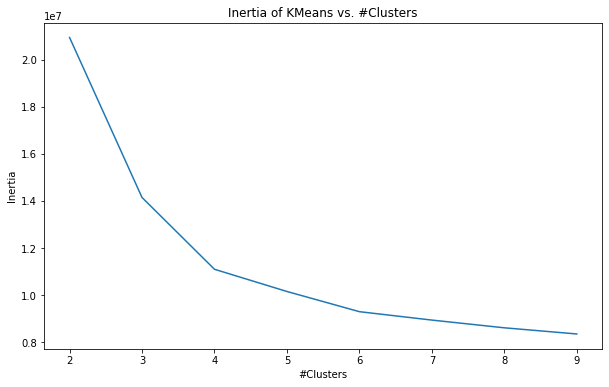

In [29]:
# Prueba para elegir el hiperparámetro 'n_clusters' variando de 2 a 9 clusters.
scores = [KMeans(n_clusters=i).fit(skillsDF).inertia_ for i in range(2, 10)]

plt.figure(figsize=(10, 6))
plt.plot(np.arange(2, 10), scores)
plt.xlabel('#Clusters')
plt.ylabel('Inertia')
plt.title('Inertia of KMeans vs. #Clusters');

**Graficamos agrupamiento de KMedias con la cantidad de clases elegida**

Visualizamos de a dos variables por vez.

In [30]:
# Elegimos dos variables arbitrarias.
skill1 = skillRating['attacking'][1] # attacking_finishing
skill2 = skillRating['defending'][2] # defending_sliding_tackle

In [31]:
fig = px.scatter(clustersDF,
                 x=skill1,
                 y=skill2,
                 color=cluster_KMeans,
                 hover_name=name,
                 hover_data=description,
                 symbol=player_class,
                 symbol_map={'TOP': 'star', 'Average': 'circle'},
                 title='Clustering KMeans',
                 height=800,
                 width=800)

fig.show()

**EVALUACIÓN**

**EJERCICIO: Análisis exploratorio de los *clusters*, usando las clases asignadas por KMeans**

- Cantidad de observaciones por Cluster.
- Análisis descriptivo separando por Cluster.
- Tabla de contingencia, alguna categórica vs. Clusters.


In [32]:
cID = 'Cluster ID'

clustersDF[cluster_KMeans].value_counts()\
                          .reset_index()\
                          .rename(columns={'index': cID, cluster_KMeans: '#Players'})\
                          .set_index(cID)\
                          .sort_index()

,#Players
Cluster ID,
0,921
1,444
2,1465
3,1682


In [33]:
pd.crosstab(clustersDF[cluster_KMeans], clustersDF[position_type])[position_order]

Position Type,Goalkeepers,Defender,Midfielder,Attacker,Others
KMeans,,,,,
0,0,504,64,0,353
1,293,0,0,0,151
2,0,4,364,478,619
3,0,397,607,23,655


**Observación**

Los agrupamientos analizados son los candidatos ideales según el *Método del Codo* que aplicamos previamente.
A simple vista, nuestra elección (`n_clusters = 4`) fue "acertada"


# 4.Clustering_con_MeanShift 

- **NO** es necesario definirle la cantidad de grupos.
- **NO** es escalable, computacionalmente es muy pesado.
- Hiperparámetros: `bandwidth` (de cobertura para cálculo de media).
- Cada dato tiene un proceso iterativo en donde en una iteración considera los vecinos a menos de un radio de distancia.

In [34]:
from sklearn.cluster import estimate_bandwidth

# Estimate BW for MeanShift.
estimated_BW = estimate_bandwidth(skillsDF, random_state=123)

print(f'BandWidth Estimado: {estimated_BW}')

# Utilizamos el ancho de banda encontrado.
ms = MeanShift(bandwidth=estimated_BW, bin_seeding=True)
ms.fit(skillsDF) # Utiliza todas las habilidades: 33 dimensiones.

# Recuperación de las etiquetas.
clusters = ms.labels_

BandWidth Estimado: 95.09050927107204


In [35]:
clustersDF[cluster_MeanShift] = clusters.astype(str) # Clusters como Variables Categóricas

print(f'MeanShift encontró {max(clusters) + 1} clusters (según los hiperparámetros elegidos)')

MeanShift encontró 1 clusters (según los hiperparámetros elegidos)


EL METODO ENCUENTRA UN SOLO GRUPO LO CUAL ES INSIGNIFICANTE PARA EL ANALISIS Claramente no nos sirve trabajar con un **único cluster**.
Se estarían agrupando todos los datos en un solo conjunto.

In [36]:
# Utilizamos un ancho de banda arbitrario.
ms = MeanShift(bandwidth=2, bin_seeding=True)
ms.fit(skillsDF) # Utiliza todas las habilidades: 33 dimensiones.

# Recuperación de las etiquetas.
clusters = ms.labels_

In [37]:
clustersDF[cluster_MeanShift] = clusters.astype(str) # Clusters como Variables Categóricas

print(f'MeanShift encontró {max(clusters) + 1} clusters (según los hiperparámetros elegidos)')

MeanShift encontró 3 clusters (según los hiperparámetros elegidos)


**Graficamos agrupamiento de MeanShift con la cantidad de clases encontradas**

Visualizamos de a dos variables por vez.

In [38]:
fig = px.scatter(clustersDF,
                 x=skill1,
                 y=skill2,
                 color=cluster_MeanShift,
                 hover_name=name,
                 hover_data=description,
                 symbol=player_class,
                 symbol_map={'TOP': 'star', 'Average': 'circle'},
                 title='Clustering MeanShift',
                 height=800,
                 width=800)

fig.show()

**EVALUACIÓN**

**EJERCICIO: Análisis exploratorio de los *clusters*, usando las clases asignadas por MeanShift**

- Cantidad de observaciones por Cluster.
- Análisis descriptivo separando por Cluster.
- Tabla de contingencia, alguna categórica vs Clusters.
- Silohuette. NO PUDE CORRERLO LO ELIMINE

In [39]:
cID = 'Cluster ID'

clustersDF[cluster_MeanShift].value_counts()\
                             .reset_index()\
                             .rename(columns={'index': cID, cluster_MeanShift: '#Players'})\
                             .set_index(cID)\
                             .sort_index()

,#Players
Cluster ID,
0,1975
1,938
2,1599


**Observación**

- El cluster **0** es el más grande, y reune jugadores defensivos con jugadores del medio campo.
- El cluster **1** es el más pequeño, se supone que agrupa principalmente jugadores del medio campo.
- El cluster **2** almacena arqueros con jugadores ofensivos, donde claramente esto no es el comportamiento que buscamos.

In [40]:
pd.crosstab(clustersDF[cluster_MeanShift], clustersDF[position_type])[position_order]

Position Type,Goalkeepers,Defender,Midfielder,Attacker,Others
MeanShift,,,,,
0,0,810,343,21,801
1,0,92,445,72,329
2,293,3,247,408,648


**Observación**

- El cluster **0** intenta separar los jugadores defensivos. Una gran parte de sus elementos corresponden a mediocampistas.
- El cluster **1** parece ser nuestro mejor agrupamiento. Una gran parte de sus elementos corresponden a jugadores del medio campo.
- El cluster **2** claramente es el peor conjunto formado. Mezcla arqueros, mediocampistas, y delanteros en un solo grupo.

# 5.Clustering_con_Agglomerative

Intentaremos aplicar un algoritmo jerárquico para encontrar agrupamientos en el conjunto de datos.

Notar que, a pensar de necesitar datos escalados, no estamos aplicando ninguna clase de estandarización.
Como ya señalamos en otros notebooks, todas las habilidades de desempeño de un jugador se encuentran entre los valores **0** y **100**, por lo que no es necesario realizar ninguna transformación al conjunto de datos de jugadores.

In [41]:
# Número de clusters buscados.
n_clust = 4

agg = AgglomerativeClustering(n_clusters=n_clust, linkage='complete', affinity='cityblock')
agg.fit(skillsDF) # Utiliza todas las habilidades: 33 dimensiones.

# Recuperación de las etiquetas.
clusters = agg.labels_

In [42]:
clustersDF[cluster_Agglomerative] = clusters.astype(str) # Clusters como Variables Categóricas

print(f'Agglomerative encontró {max(clusters) + 1} clusters (nosotros forzamos la cantidad)')

Agglomerative encontró 4 clusters (nosotros forzamos la cantidad)


**Graficamos agrupamiento de Agglomerative con la cantidad de clases elegida**

Visualizamos de a dos variables por vez.

In [43]:
fig = px.scatter(clustersDF,
                 x=skill1,
                 y=skill2,
                 color=cluster_Agglomerative,
                 hover_name=name,
                 hover_data=description,
                 symbol=player_class,
                 symbol_map={'TOP': 'star', 'Average': 'circle'},
                 title='Clustering Agglomerative',
                 height=800,
                 width=800)

fig.show()

**EVALUACIÓN**

**EJERCICIO: Análisis exploratorio de los *clusters*, usando las clases asignadas por Agglomerative**

- Cantidad de observaciones por Cluster.
- Análisis descriptivo separando por Cluster.
- Tabla de contingencia, alguna categórica vs. Clusters.
- Silohuette.

In [44]:
cID = 'Cluster ID'

clustersDF[cluster_Agglomerative].value_counts()\
                                 .reset_index()\
                                 .rename(columns={'index': cID, cluster_Agglomerative: '#Players'})\
                                 .set_index(cID)\
                                 .sort_index()

,#Players
Cluster ID,
0,1693
1,1136
2,1239
3,444


**Observación**

- El cluster **0** es el más grande, y reune en su mayoría a jugadores defensivos.
- El cluster **1** almacena principalmente jugadores ofensivos, donde hay que notar que **NO** hay estrellas.
- El cluster **2** tiene una estructura extraña, ya que su extensión abarca jugadores del medio campo y jugadores ofensivos.
- El cluster **3** es el más pequeño, debido a que agrupa exclusivamente a los arqueros.

In [45]:
pd.crosstab(clustersDF[cluster_Agglomerative], clustersDF[position_type])[position_order]

Position Type,Goalkeepers,Defender,Midfielder,Attacker,Others
Agglomerative,,,,,
0,0,805,237,1,650
1,0,3,300,320,513
2,0,97,498,180,464
3,293,0,0,0,151


**Observación**

- El cluster **0** separa a los jugadores defensivos de forma satisfactoria. Selecciona a algunos mediocampistas, pero considera prácticamente la totalidad de los defensores.
- El cluster **1** no es tan bueno para separar los jugadores ofensivos. Una enorme parte de sus elementos corresponden a mediocampistas, casi la mitad.
- El cluster **2** separa a los jugadores del medio campo de forma moderada. Selecciona a algunos delanteros, pero es un número relativamente manejable.
- El cluster **3** separa a los arqueros del resto de jugadores prácticamente a la perfección. Probablemente sea el agrupamiento más facil de realizar.